## The challenge is to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell using a given data set.
#### 1) Load and transform data into proper format (features as columns and datapoints as rows)
#### 2) Deal with missing values and/or mislabeled data. Feature Engineering
#### 3) Explore data - look for trends
#### 4) Explore potential models and model selection
#### 5) Make sure model assumptions are met, hyperparameter optimization and further feature engineering if necessary
#### 6) Test model
#### 7) Conclusion and Insights

## 1) Load and transform data

In [70]:
import pandas as pd
import operator
import seaborn as sns
import numpy as np 
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
#importing libraries to be used in this challenge

%matplotlib inline

#URL to data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'

#Putting data into a useable format - pandas dataframe
df = pd.read_csv(url, header=None, names=['ID','Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                                         'Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin',
                                         'Normal Nucleoli','Mitoses','Class'])

In [6]:
df.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [78]:
df['Class'] = df['Class'].replace(2,0)
df['Class'] = df['Class'].replace(4,1) #Here I am just changing the class labels to 0 and 1 for easier interpretability

In [79]:
df.Class.value_counts() #Assessing the class imbalance here

0    458
1    241
Name: Class, dtype: int64

In [80]:
print len(df) #Assessing size of df

699


## 2) Check for missing values

In [81]:
df.isnull().sum() ## There are no missing values - however, I will check if there are any values that aren't missing 
##but that don't make sense (like a clump thickiness of 600 for instance)

ID                             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

## 3) Explore data

In [82]:
#defining a function to plot each feature against the target variable to see if there are any obvious trends in the data.
# Since the data is categorical many data points would overlap in a traditional scatter plot and therefore I am 
# choosing to use a jitter plot, which basically adds a bit of 'jitter' to the data to spread the points apart. 
def plot_features(col_list, title):
    plt.figure(figsize=(10,14));
    i = 0
    for col in col_list:
        i += 1
        plt.subplot(5,2,i)
        sns.stripplot(df[col],df['Class'], jitter=True)
        plt.title(title % (col))
        plt.tight_layout()

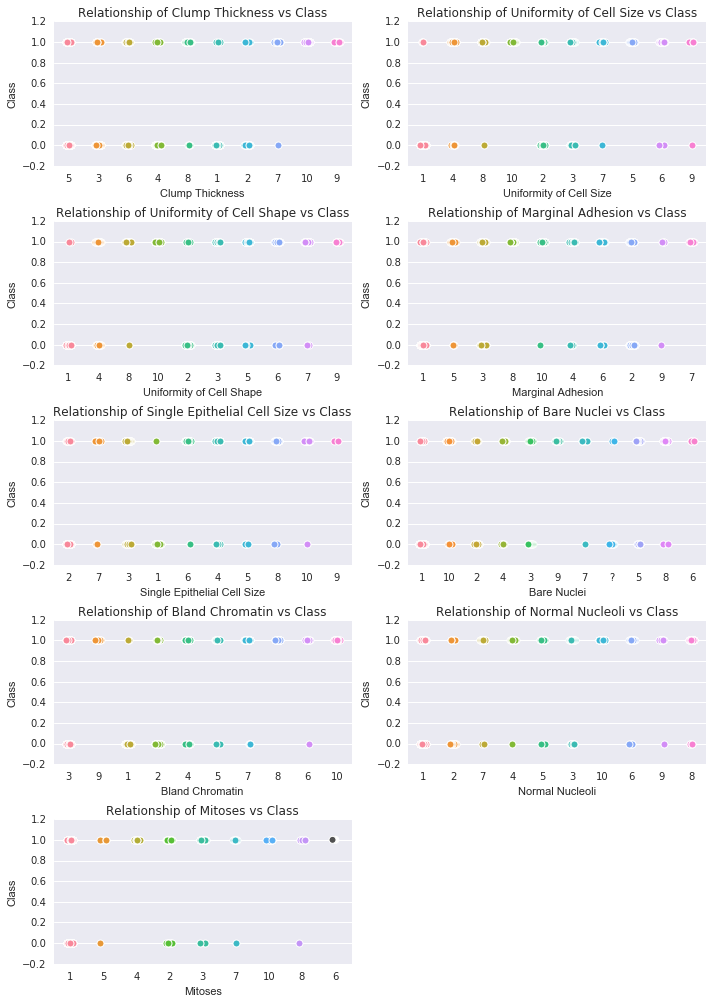

In [83]:
plot_features(cols, "Relationship of %s vs Class")
#There are some obvious trends here - For instance a clump thicknickess of 9 or 10 and a cell shape value of 9 or 10 
#seem to only be present in the metastatic class.

In [85]:
df['Mitoses'].value_counts() # Just checking the values of the Mitoses column because I wanted to investigae the dark 
#circle was for #6 in the mitoses graph above. 

1     579
2      35
3      33
10     14
4      12
7       9
8       8
5       6
6       3
Name: Mitoses, dtype: int64

In [95]:
df.info() #Just looking at the type of each feature to make sure they are all floats or ints

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID                             699 non-null int64
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [96]:
#Not sure why 'Bare Nuclei' is not an int so I will explore this further
df['Bare Nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare Nuclei, dtype: int64

In [ ]:
# I don't know what the ? are - there is no indication to whether or not they are meant to be a different value. 
#Since I have no indication of what they are supposed to be, I will assume they are missing values and will drop them.

In [184]:
df['Bare Nuclei'].replace('?',np.nan, inplace=True)
df['Bare Nuclei'] = df['Bare Nuclei'].astype(int)
df.info() #There should now be 16 missing values for Bare Nuclei

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
ID                             683 non-null int64
Clump Thickness                683 non-null int64
Uniformity of Cell Size        683 non-null int64
Uniformity of Cell Shape       683 non-null int64
Marginal Adhesion              683 non-null int64
Single Epithelial Cell Size    683 non-null int64
Bare Nuclei                    683 non-null int64
Bland Chromatin                683 non-null int64
Normal Nucleoli                683 non-null int64
Mitoses                        683 non-null int64
Class                          683 non-null int64
dtypes: int64(11)
memory usage: 64.0 KB


In [104]:
df.dropna(inplace=True) #Dropping the missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
ID                             683 non-null int64
Clump Thickness                683 non-null int64
Uniformity of Cell Size        683 non-null int64
Uniformity of Cell Shape       683 non-null int64
Marginal Adhesion              683 non-null int64
Single Epithelial Cell Size    683 non-null int64
Bare Nuclei                    683 non-null object
Bland Chromatin                683 non-null int64
Normal Nucleoli                683 non-null int64
Mitoses                        683 non-null int64
Class                          683 non-null int64
dtypes: int64(10), object(1)
memory usage: 64.0+ KB


## 4) Explore Models and Model Selection

In [87]:
## I'm choosing a few supervised learning algorithms to explore. 

In [201]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split 
from sklearn.cross_validation import cross_val_score 
from sklearn.metrics import (auc, roc_curve, roc_auc_score,
                             accuracy_score, precision_score,
                             recall_score, f1_score, )
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [89]:
#The classes are unbalanced so I am rebalancing them in the respectove classifiers
logistic = LogisticRegression(class_weight='balanced')
treeclf = DecisionTreeClassifier(class_weight='balanced')
forest = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')
svc_lin = SVC(class_weight='balanced', kernel='linear')
knn = KNeighborsClassifier()

In [106]:
# Splitting the data into training and testing data
X = df[cols]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [109]:
#Defining a function to calculate metrics on the various classifiers for easy comparison
def classifier_metrics_accuracy(clf):
    clf.fit(X_train, y_train)
    
    print '%30s: %s' % ('Default score (accuracy)', clf.score(X_train, y_train))
    print '%30s: %s' % ('Cross val score', cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
    print '%30s: %s' % ('AUC', (cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()))
    print '%30s: %s' % ('Precision', (cross_val_score(clf, X_train, y_train, cv=5, scoring='precision_weighted').mean()))
    print '%30s: %s' % ('Recall', (cross_val_score(clf, X_train, y_train, cv=5, scoring='recall_weighted').mean()))
    print '%30s: %s' % ('F1', (cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted').mean()))
    print '\n'

In [110]:
for clf in [logistic, treeclf, forest, svc, knn, svc_lin]: 
    print 'Metrics for %s' % clf
    print '=' * 50
    classifier_metrics_accuracy(clf)

Metrics for LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
      Default score (accuracy): 0.972527472527
               Cross val score: 0.96525376085
                           AUC: 0.992611974139
                     Precision: 0.965906401932
                        Recall: 0.96525376085
                            F1: 0.965362968722


Metrics for DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
      Default score (accuracy): 1.0
               Cross val score: 0.941416612609
                      

In [122]:
## The Logistic Regression and SVC have the highest cross validation scores meaning that they are generalizing well and
#also have the highest AUC scores which means they are optimizing true positives while minimizing false positives. 
#Especially in a breast cancer scenario, we want to make sure we optimize both of these things. 
#Since the logistic and SVC are performing similarly but the logistic regression is the simpler model and a lot less
#computationally expensive then the SVC I will use the logistic regression model.

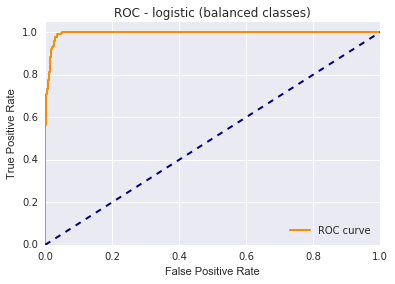

In [123]:
#visualizing the ROC curve for the logistic regression

y_score = logistic.fit(X_train, y_train).decision_function(X_train)

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_train, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - logistic (balanced classes)')
plt.legend(loc="lower right")
plt.show()

## 5) Further Feature Engineering and Hyperparameter Optimization

In [ ]:
#For a logistic regression the data do not need to be linearly related or follow a normal distribution. However,
#this model does assume independence of features and therefore features should not be correlated. 

In [187]:
#Checking correlations between features - r^2 threshold of .75 or above is considered strongly correlated. 
correlations = {}
for col_a, col_b in itertools.combinations(cols, 2):
    correlations[col_a + '__' + col_b] = pearsonr(df.loc[:, col_a], df.loc[:, col_b])

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']

print(result.sort_index())

                                                         PCC        p-value
Bare Nuclei__Bland Chromatin                        0.680615   4.391890e-94
Bare Nuclei__Mitoses                                0.339210   7.473326e-20
Bare Nuclei__Normal Nucleoli                        0.584280   9.158074e-64
Bland Chromatin__Mitoses                            0.346011   1.214400e-20
Bland Chromatin__Normal Nucleoli                    0.665602   1.312645e-88
Clump Thickness__Bare Nuclei                        0.593091   4.050902e-66
Clump Thickness__Bland Chromatin                    0.553742   3.880813e-56
Clump Thickness__Marginal Adhesion                  0.487829   4.027956e-42
Clump Thickness__Mitoses                            0.350957   3.148289e-21
Clump Thickness__Normal Nucleoli                    0.534066   1.260114e-51
Clump Thickness__Single Epithelial Cell Size        0.523596   2.411759e-49
Clump Thickness__Uniformity of Cell Shape           0.653470   2.064616e-84
Clump Thickn

In [191]:
#Removing the feature 'Uniformity of Cell Size' because it is strongly correlated with 3 other features.
cols_nocellsize = ['Clump Thickness',
 'Uniformity of Cell Shape',
 'Marginal Adhesion',
 'Single Epithelial Cell Size',
 'Bare Nuclei',
 'Bland Chromatin',
 'Normal Nucleoli',
 'Mitoses']
X = df[cols_nocellsize]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [192]:
#Trying a variety of C parameters and solvers

In [193]:
PARAMETERS = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag']}
SCORING = 'accuracy'

from sklearn import grid_search

#Grid Search
model = LogisticRegression(class_weight='balanced')
clf = grid_search.GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True)
clf.fit(X_train, y_train)

#After completion, show the final best results and scores
print clf.best_estimator_
print clf.best_score_

Fitting 3 folds for each of 28 candidates, totalling 84 fits
LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.970695970696


[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    1.2s finished


In [194]:
# Trying out L1 vs L2 regularization

PARAMETERS = {'penalty':['l1','l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
SCORING = 'accuracy'

from sklearn import grid_search

#Grid Search
model = LogisticRegression(class_weight='balanced')
clf = grid_search.GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True)
clf.fit(X_train, y_train)

#After completion, show the final best results and scores
print clf.best_estimator_
print clf.best_score_

Fitting 3 folds for each of 14 candidates, totalling 42 fits
LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.970695970696


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.3s finished


## 6) Evaluating the Model

In [202]:
logistic_model = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)
## Using the optimized model

In [203]:
clf = logistic_model.fit(X_train, y_train)
clf.coef_ #Looking at the most important features

array([[ 0.31807339,  0.34710463,  0.22013371, -0.06557374,  0.37504013,
         0.23237369,  0.25453434,  0.26385169]])

In [197]:
X_train.columns

Index([u'Clump Thickness', u'Uniformity of Cell Shape', u'Marginal Adhesion',
       u'Single Epithelial Cell Size', u'Bare Nuclei', u'Bland Chromatin',
       u'Normal Nucleoli', u'Mitoses'],
      dtype='object')

In [198]:
important_features = zip(X_train.columns, clf.coef_.ravel())
sorted(important_features, key=operator.itemgetter(1), reverse=True)
#The most important features have the highest coefficients however coefficients should be interpretted with caution such
# that .37 unit change in Bare Nuclei is associated with a 1 unit change in the target. This is not a meaningful
# interpretation for categorical data. 

[('Bare Nuclei', 0.37503447770755555),
 ('Uniformity of Cell Shape', 0.3474262227533515),
 ('Clump Thickness', 0.31806665670194295),
 ('Mitoses', 0.26383160056804084),
 ('Normal Nucleoli', 0.2545885257613919),
 ('Bland Chromatin', 0.23212793038390475),
 ('Marginal Adhesion', 0.2202720122373551),
 ('Single Epithelial Cell Size', -0.065432943485218178)]

In [199]:
y_eval = clf.predict(X_test)

In [200]:
print "Overall model accuracy is %s" % (accuracy_score(y_test, y_eval))

Overall model accuracy is 0.992700729927


In [204]:
print classification_report(y_test, y_eval, labels=[0, 1])

             precision    recall  f1-score   support

          0       0.99      1.00      0.99        90
          1       1.00      0.98      0.99        47

avg / total       0.99      0.99      0.99       137



In [205]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=22)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

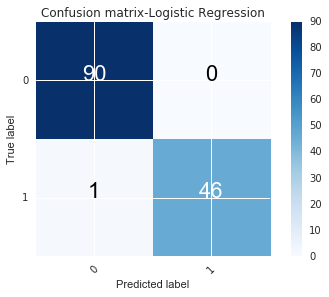

In [206]:
conf_logistic = confusion_matrix(y_test, y_eval)
plot_confusion_matrix(conf_logistic, classes=[0, 1], title = 'Confusion matrix-Logistic Regression')
plt.show()

## 7) Conclusions and Insights

### I used a logistic regression classifier to classify benign and malignant breast cancer samples. I removed missing values and highly correlated features from the data set before splitting the data into test and training data. Since the two classes were unbalanced to begin with, I rebalanced classes using the built-in functionality in sklearn (setting weights=balanced). I optimized the hyperparameters of the logistic regression by trying different C parameters and solvers. The model generalized well as evidenced by similar accuracy scores in the training and testing data. Finally, to validate the model I used a confusion matrix which showed that only 1 sample was misclassified and it was a false negative. In the scenario of breast cancer it is really important to minimize false negatives as the repercussions of a person with breast cancer going untreated are far worse than the opposite case of a false positive where a person is told they have breast cancer and goes through additional screenings to find out that they actually do not have breast cancer. In the future I could optimize this model further to remove false negatives at the expense of generating more false positives. Important features for this model include Bare Nuclei, Uniformity of Cell Shape, and Clump Thickness.